In [14]:
#Import libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [15]:
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

from datetime import datetime
import math
def parse_time(x):
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.timetuple().tm_yday

def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return (dt.hour * 60 + dt.minute) / 1440

metadata = pd.read_csv('archive/metaData_taxistandsID_name_GPSlocation.csv')
longlatTable = []
for i in range(0, 63):
    longlatTable.append([metadata[i:i+1].Latitude.values[0], metadata[i:i+1].Longitude.values[0]])

maxLat = np.max(np.array(longlatTable)[:, 0])
minLat = np.min(np.array(longlatTable)[:, 0])
maxLong = np.max(np.array(longlatTable)[:, 1])
minLong = np.min(np.array(longlatTable)[:, 1])

def parse_origin_cal_lat_long(x):
    if math.isnan(x['ORIGIN_STAND']):
        return 0, 0
    lat, long = longlatTable[ round(x['ORIGIN_STAND']) - 1][0], longlatTable[round(x['ORIGIN_STAND']) - 1][1]
    
    return (lat - minLat) / (maxLat - minLat), (long - minLong) / (maxLong - minLong)

In [16]:
def processCSV(csvname):
  xg_train = pd.read_csv(csvname)
  df_tr = xg_train
  if "POLYLINE" not in df_tr: #test dataset
    df_tr["POLYLINE"]="[[["
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
  else: 
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
    mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
    median = df_tr["LEN"].median()
    outlier_threshold = 3
    print(mean, std)
    df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
    df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
    print("Before Trimming: " + str(len(df_tr)))
    print("After Trimming: " + str(len(df_trimmed)))
    df_tr = df_trimmed
    # first trim the dataset

  df_tr[["YR", "MON", "DAY", "HR", "WK", "DAYOFYEAR"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
  df_tr["MIDMINS"] = df_tr[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
  
  LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
  df_trimmed_copy = df_tr
  # print('there was ' + str(len(df_trimmed_copy['LEN'] == 0)) + " zeroes")
  # df_trimmed_copy = df_trimmed_copy[df_trimmed_copy['LEN'] != 0]
  y_train = df_trimmed_copy["LEN"]
  df_trimmed_copy["CALL_TYPE"] = df_trimmed_copy["CALL_TYPE"].map(LetterToIndex)
  # df_trimmed_copy["DAY_TYPE"] = df_trimmed_copy["DAY_TYPE"].map(LetterToIndex)
  #took out "TRIP_ID"
  # x_train = df_trimmed_copy[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "MIDMINS"]]
  return df_trimmed_copy, y_train

In [17]:
x_train_unfiltered, y_train = processCSV('archive/train.csv')
x_train = x_train_unfiltered[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "HR", "WK", "DAYOFYEAR", "MIDMINS"]]
y_train = x_train_unfiltered['LEN']

716.4264615618442 684.7511617510816
Before Trimming: 1710670
After Trimming: 1692763


In [18]:
#Load in saved best model
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xg_model = xgb.Booster()
xg_model.load_model('best_performing_model.json')


In [19]:
#Load in test and convert categorical columns to category in df
test_x, test_y = processCSV('archive/test_public.csv')
test_x = test_x.drop(columns=["DAY_TYPE", "MISSING_DATA", 'POLYLINE', 'LEN', 'TIMESTAMP', 'DAY'])
test_x['CALL_TYPE'] = test_x['CALL_TYPE'].astype('category')
test_x['ORIGIN_CALL'] = test_x['ORIGIN_CALL'].astype('category')
test_x['ORIGIN_STAND'] = test_x['ORIGIN_STAND'].astype('category')
test_x['TAXI_ID'] = test_x['TAXI_ID'].astype('category')
test_x['YR'] = test_x['YR'].astype('category')
test_x['MON'] = test_x['MON'].astype('category')
test_x['HR'] = test_x['HR'].astype('category')
test_x['WK'] = test_x['WK'].astype('category')
test_x['DAYOFYEAR'] = test_x['DAYOFYEAR'].astype('category')
y_pred = xg_model.predict(xgb.DMatrix(test_x.drop(columns=['TRIP_ID']), enable_categorical=True))

In [20]:
#Convert predictions into a CSV after performing transformation
ids = test_x["TRIP_ID"].values
for i in range(len(y_pred)):
#     y_pred[i] = y_pred[i]
    y_pred[i] = max(0, y_pred[i] - 150) #Subtract 150 from each value and change negative values to 0
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : y_pred}
newdf = pd.DataFrame(d)
newdf.to_csv("SeeForYourself.csv", index=None)

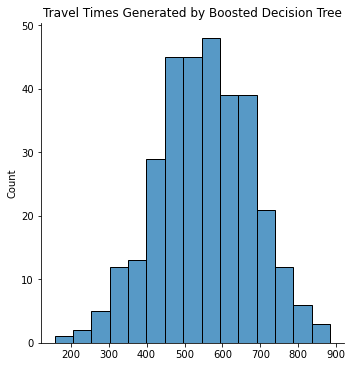

In [21]:
#Display histogram of results
import seaborn as sns
sns.displot(y_pred).set(title='Travel Times Generated by Boosted Decision Tree')